In [19]:
import os
import sys
import scipy.fftpack
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
from skimage import measure
from shutil import copyfile, move
import subprocess

currdir = os.getcwd()
e0 = 1.601 * 1.e-19;
mu0 = 4.0 * np.pi * 1.e-7;
nchease = 401;

class eqdsk:

	def read_1d(self,file,num):
	
		dat = np.zeros(num)
		
		linen = int(np.floor(num/5))
		
		ii = 0
		
		for i in range(linen):
		
			line = file.readline()
			
			for j in range(5):
				
				dat[ii] = float(line[16*j:16*(j+1)])
				ii = ii + 1
		
		if not (num == 5*linen):
			line = file.readline()
		
		for i in range(num - 5*linen):
		
			dat[ii] = float(line[16*i:16*(i+1)])
			ii = ii + 1
			
		return (dat)

	def read_colum(self,file,num):
	
		dat = np.zeros(shape=(num,2))
		
		dat1 = self.read_1d(file,num*2)
		
		for i in range(num):
		
			dat[i,0] = dat1[2*i]
			dat[i,1] = dat1[2*i+1]
			
		return (dat)
		
	def read_2d(self,file,num1,num2):
	
		dat = np.zeros(shape=(num1,num2))
		
		dat1 = self.read_1d(file,num1*num2)
		
		ii = 0
		
		for i in range(num1):
		
			for j in range(num2):
			
				dat[i,j] = dat1[ii]
				ii = ii + 1
				
		return (dat)

	def read_eqdsk(self,filename):
	
		file = open(filename,'r')
		
		line = file.readline().split()#
		linen = len(line)

		self.id = []
	
		if linen > 4:
			for i in range(linen-4):
				self.id.append(line[i])
		self.shotn = 0
		try:
			if (self.id[0].find('EFIT')>-1):
				self.shotn = int(self.id[3])
		except:
			pass
  
		self.idum = int(line[linen-3])	
		self.nw = int(line[linen-2])
		self.nh = int(line[linen-1])
		
		line = file.readline()#
		self.rdim = float(line[0:16])
		self.zdim = float(line[16:32])
		self.rcentr = float(line[32:48])
		self.rleft = float(line[48:64])
		self.zmid = float(line[64:80])
		
		line = file.readline()#
		self.rmag = float(line[0:16])
		self.zmag = float(line[16:32])
		self.smag = float(line[32:48])
		self.sbdy = float(line[48:64])
		self.bcentr = float(line[64:80])
		
		line = file.readline()#
		self.ip = float(line[0:16])
		self.xdum = float(line[32:48])
		
		line = file.readline()#
		
		self.fpol = self.read_1d(file,self.nw)
		self.pres = self.read_1d(file,self.nw)
		self.ffp = self.read_1d(file,self.nw)
		self.pp = self.read_1d(file,self.nw)
		self.psirz = self.read_2d(file,self.nh,self.nw)
		self.q = self.read_1d(file,self.nw)
		
		line = file.readline().split()
		self.nbbbs = int(line[0])
		self.limitr = int(line[1])
		
		self.rzbdy = self.read_colum(file,self.nbbbs)
		self.rzlim = self.read_colum(file,self.limitr)
  
		return
		
	def make_grid(self):
	
		self.R = np.zeros(self.nw)
		self.Z = np.zeros(self.nh)
		self.psin = np.linspace(0,1,self.nw)
	
		for i in range(self.nw):
			self.R[i] = self.rleft + float(i)*self.rdim/(self.nw-1)
		for i in range(self.nh):
			self.Z[i] = self.zmid + float(i)*self.zdim/(self.nh-1) - self.zdim / 2.
			
		self.RR, self.ZZ = np.meshgrid(self.R,self.Z)
			
		return
	
	def get_flux_contour(self):
	
		Rmax = max(self.rzbdy[:,0])*1.001
		Rmin = min(self.rzbdy[:,0])*0.999
		Zmax = max(self.rzbdy[:,1])
		Zmin = min(self.rzbdy[:,1])
		
		self.Rcntr = np.linspace(Rmin,Rmax,self.nw)
		self.Zcntr = np.linspace(Zmin,Zmax,self.nh)

		RR, ZZ = np.meshgrid(self.Rcntr,self.Zcntr)
		
		psif = interp2d(self.R,self.Z,self.psirz)
		self.PSIRZ = psif(self.Rcntr,self.Zcntr)
		return
	    
	def contour(self,psin):

		cs = measure.find_contours(self.PSIRZ,psin)
		for cc in cs:
			cc[:,1] = cc[:,1] * (max(self.Rcntr)-min(self.Rcntr))/(len(self.Rcntr)-1.) + min(self.Rcntr)
			cc[:,0] = cc[:,0] * (max(self.Zcntr)-min(self.Zcntr))/(len(self.Zcntr)-1.) + min(self.Zcntr)
	
		rz = np.copy(cs[0])
		rz[:,0] = cs[0][:,1]
		rz[:,1] = cs[0][:,0]

		return rz
	
	def get_target_bnd(self):
	
		psint = self.target_psin * (self.sbdy - self.smag) + self.smag
	
		self.rzbdyt = self.contour(psint)
		
		return
		
	def smooth_bnd(self):
	
		if (self.target_psin == 0):
			rz = np.copy(self.rzbdy)
		else:
			rz = np.copy(self.rzbdyt)
			
		len2 = len(rz)
		
		rcen = (max(rz[:,0])+min(rz[:,0]))*0.5
		ind = rz[:,0].argmax()
		zcen = rz[ind,1]
		amin = (max(rz[:,0])-min(rz[:,0]))*0.5
		
		rad = np.zeros(len2)
		rad2 = np.zeros(len2)
		theta = np.zeros(len2)
		theta2 = np.zeros(len2)
		
		for i in range(len2):
		
			rad2[i] = np.sqrt((rz[i,0]-rcen)**2 + (rz[i,1]-zcen)**2) / amin
			theta2[i] = np.arctan2(rz[i,1]-zcen,rz[i,0]-rcen)
				
		ind = theta2.argsort()
		
		for i in range(len2):
	
			rad[i] = rad2[ind[i]]
			theta[i] = theta2[ind[i]]
			
		rad2 = np.zeros(len2*2)
		theta2 = np.zeros(len2*2)
		
		for i in range(len2):
			rad2[i] = rad[i]
			theta2[i] = theta[i]
			rad2[i+len2] = rad[i]
			theta2[i+len2] = theta[i] + 2.0*np.pi

		ik = 0
		chk_in = np.zeros(len2)
		for i in range(2*len2-1):
			if (theta2[i] == theta2[i+1]):
				ik = ik + 1
		rad3 = np.zeros(len2*2 - ik)		
		theta3 = np.zeros(len2*2 - ik)
		
		ii = 0
		for i in range(2*len2 -1):
			if (theta2[i] < theta2[i+1]):
				rad3[ii] = rad2[i]
				theta3[ii] = theta2[i]
				ii = ii + 1
				
		if (ik == (2*len2 - ii - 1)):
				rad3[ii] = rad2[-1]
				theta3[ii] = theta2[-1] 
				
		thetafine = np.linspace(0,2*np.pi,self.nf)
		radf = interp1d(theta3,rad3,'cubic')
		radfine = radf(thetafine)

		four = scipy.fftpack.fft(radfine,n=self.nf)
		self.realfour=2.0*four.real[:int(self.nf/2)]/float(self.nf)
		self.imagfour=-2.0*four.imag[:int(self.nf/2)]/float(self.nf)
		
		ifour = scipy.fftpack.ifft(four,n=self.nf)
		ifour = ifour.real
	
		self.rzbdys = np.zeros(shape=(self.nf,2))
	
		for i in range(self.nf):
		
			self.rzbdys[i,0] = rcen + ifour[i]*amin*np.cos(thetafine[i])
			self.rzbdys[i,1] = zcen + ifour[i]*amin*np.sin(thetafine[i])
						
		return

	def make_rho_R_psin(self):
	
		self.prhoR = np.zeros(shape=(201,4))
		
		self.prhoR[:,0] = np.linspace(0,1.0,201)
		
		RR = np.linspace(self.rmag,max(self.R)*0.999,301)
		RR2 = np.linspace(min(self.R)*1.001,self.rmag,301)
		
		psif = interp2d(self.R,self.Z,self.psirz)
		
		psir = psif(RR,self.zmag)
		psir2 = psif(RR2,self.zmag)

		psirn = np.zeros(301)
		psirn2 = np.zeros(301)
		
		for i in range(301):
			psirn[i] = (psir[i]-self.smag)/(self.sbdy - self.smag)
			psirn2[i] = (psir2[i]-self.smag)/(self.sbdy - self.smag)

		psirn[0] = 0.0;
		psirn2[-1] = 0.0;
		
		prf = interp1d(psirn,RR,'cubic')
		prf2 = interp1d(psirn2,RR2,'cubic')
		
		self.prhoR[:,2] = prf(self.prhoR[:,0])
		self.prhoR[0,2] = self.rmag

		self.prhoR[:,3] = prf2(self.prhoR[:,0])
		self.prhoR[0,3] = self.rmag
		
		qf = interp1d(self.psin,self.q,'cubic')
		q = qf(self.prhoR[:,0])
		
		for i in range(200):
			self.prhoR[i+1,1] = np.trapz(q[0:i+2],x=self.prhoR[0:i+2,0])
			
		for i in range(201):
			self.prhoR[i,1] = np.sqrt(self.prhoR[i,1] / self.prhoR[-1,1])
			
	
		rhof = interp1d(self.prhoR[:,0],self.prhoR[:,1],'slinear')
		self.rho = rhof(self.psin)

		return

	def construct_volume(self):

		len1 = len(self.rzbdy)
		len2 = 101
		psin = np.linspace(0,1.,len2)
		self.avolp = np.zeros(shape=(len2,3))
		
		self.psif = interp2d(self.R,self.Z,(self.psirz-self.smag)/(self.sbdy-self.smag))
		r = np.zeros(shape=(len1,len2))
		z = np.zeros(shape=(len1,len2))
		for i in range(len1):
			rr = np.linspace(self.rmag,self.rzbdy[i,0],len2)
			zz = (self.rzbdy[i,1]-self.zmag)/(self.rzbdy[i,0]-self.rmag)*(rr-self.rmag) + self.zmag
			psi = np.zeros(len2)
			for j in range(len2):
				psi[j] = self.psif(rr[j],zz[j])

			psi[0] = 0.0;
			psi[-1] = 1.0;
			psifr = interp1d(psi,rr,'cubic')
			r[i,:] = psifr(psin)
			z[i,:] = (self.rzbdy[i,1]-self.zmag)/(self.rzbdy[i,0]-self.rmag)*(r[i,:]-self.rmag) + self.zmag


	#	bpf = interp2d(self.r,self.z,self.bn)
		sum1 = 0.
		sum2 = 0.
		sum3 = 0.
		for i in range(len2-1):
			for j in range(len1):
				i1 = i + 1
				j1 = j + 1
				if (j1 == len1):
					j1 = 0

				dx1 = r[j1,i1] - r[j,i]
				dz1 = z[j1,i1] - z[j,i]
				dx2 = r[j1,i]  - r[j,i1]
				dz2 = z[j1,i]  - z[j,i1]
				dx3 = r[j1,i1]  - r[j,i1]
				dz3 = r[j1,i1]  - r[j,i1]

				dl1 = np.sqrt(dx1**2 + dz1**2)
				dl2 = np.sqrt(dx2**2 + dz2**2)
				cos = (dx1*dx2 + dz1*dz2)/dl1/dl2

				if (abs(cos) > 1):	cos = 1.
				sin = np.sqrt(1.0 - cos**2)
				dA = 0.5*dl1*dl2*sin
				Rc = 0.25*(r[j,i]+r[j1,i]+r[j,i1]+r[j1,i1])
				Zc = 0.25*(z[j,i]+z[j1,i]+z[j,i1]+z[j1,i1])
				sum1 = sum1 + dA
				sum2 = sum2 + 2.*np.pi*Rc*dA
		#		sum3 = sum3 + 2.*np.pi*Rc*dA*(bpf(Rc,Zc)**2)

			self.avolp[i+1,0] = psin[i+1]
			self.avolp[i+1,1] = sum1
			self.avolp[i+1,2] = sum2

		pref = interp1d(self.psin,self.pres,'cubic')
		pres = pref(psin)

		self.wmhd = np.trapz(pres,x=self.avolp[:,2]) * 1.5;
		self.area = self.avolp[-1,1]
		self.vol  = self.avolp[-1,2]
		self.pva = self.wmhd / 1.5 / self.avolp[-1,2]
	#	self.bp2v = sum3

		return
		
	def construct_2d_field(self):

		self.br = np.zeros(shape=(self.nh-2,self.nw-2))
		self.bz = np.copy(self.br)
		self.bt = np.copy(self.br)
		self.r = np.zeros(self.nw-2)
		self.z = np.zeros(self.nh-2)

		for i in range(self.nh-2):
			self.z[i] = self.Z[i+1]
		for i in range(self.nw-2):
			self.r[i] = self.R[i+1]

		psif = interp2d(self.R,self.Z,self.psirz)

		fpf = interp1d(self.psin,self.fpol,'cubic')

		for i in range(self.nh-2):
			Z = self.Z[i+1]
			for j in range(self.nw-2):
				R = self.R[j+1]
				psi = (psif(R,Z)-self.smag) / (self.sbdy - self.smag)
				if (psi < 0.0):
					psi = 0.0

				self.br[i,j] = - (self.psirz[i+2,j+1] - self.psirz[i,j+1]) / (self.Z[i+2] - self.Z[i]) / R
				self.bz[i,j] = + (self.psirz[i+1,j+2] - self.psirz[i+1,j]) / (self.R[j+2] - self.R[j]) / R

				if (psi < 1.0):
					self.bt[i,j] = fpf(psi) / R
				else:
					self.bt[i,j] = self.fpol[-1] / R
		return	
		
	def surface_zjz(self):
	
		self.psinh = np.linspace(0.01,1.,401)
	
		num = len(self.psinh)
	
		self.avg1 = np.zeros(num)
		self.avg2 = np.zeros(num)
		self.avg3 = np.zeros(num)
		self.zjzh = np.zeros(num)
	
		for i in range(num-2):
			psint = self.psinh[i+1] * (self.sbdy - self.smag) + self.smag
			rz = self.contour(psint)
				
			len2 = len(rz)
			sum1 = 0
			sum2 = 0
			sum3 = 0
			
			for j in range(len2-1):
				dr = abs(rz[j,0]-rz[j+1,0])
				dz = abs(rz[j,1]-rz[j+1,1])
				
				ds = np.sqrt(dr**2.0 + dz**2.0)
				
				sum1 = sum1 + ds
				sum2 = sum2 + ds * 0.5 * (rz[j,0]+rz[j+1,0])
				sum3 = sum3 + ds / 0.5 / (rz[j,0]+rz[j+1,0])
				
			dr = abs(rz[0,0]-rz[-1,0])
			dz = abs(rz[0,1]-rz[-1,1])
			
			ds = np.sqrt(dr**2.0 + dz**2.0)
			
			sum1 = sum1 + ds
			sum2 = sum2 + ds * 0.5 * (rz[0,0]+rz[-1,0])
			sum3 = sum3 + ds / 0.5 / (rz[0,0]+rz[-1,0])
			
			self.avg1[i+1] = sum1
			self.avg2[i+1] = sum2/sum1
			self.avg3[i+1] = sum3/sum1
			

		
		self.avg1[-1] = 2.0*self.avg1[num-2] - self.avg1[num-3]
		self.avg2[-1] = 2.0*self.avg2[num-2] - self.avg2[num-3]
		self.avg3[-1] = 2.0*self.avg3[num-2] - self.avg3[num-3]
		
		self.avg2[0] = self.rmag
		self.avg3[0] = 1.0/self.rmag
		
		ppf = interp1d(self.psin,self.pp,'cubic')
		fpf = interp1d(self.psin,self.ffp,'cubic')
		
		for i in range(num):
			pp = ppf(self.psinh[i])
			ff = fpf(self.psinh[i])
		
			self.zjzh[i] = -self.avg2[i]*pp - ff*self.avg3[i]/mu0
			
		return
	
	def make_chease_expeq(self,filename='EXPEQ'):
	
		f4 = open(filename,'w')
	
		if (self.use_bnd_smooth):
			self.smooth_bnd()
			rz = self.rzbdys
		else:
			if (self.target_psin == 0):
				rz = self.rzbdy
			else:
				rz = self.rzbdyt
	
		rcen = (max(rz[:,0])+min(rz[:,0]))*0.5
		ind = rz[:,0].argmax()
		zcen = rz[ind,1]
		amin = (max(rz[:,0])-min(rz[:,0]))*0.5
		
		self.ASPCT = amin/rcen
		self.R0EXP = rcen
		self.B0EXP = self.rcentr  * abs(self.bcentr) / rcen

		f4.write('%f \n'%self.ASPCT)
		f4.write('%f \n'%zcen)
		if not (self.zeroedgep):
			f4.write('%f \n'%(mu0 * self.pres[-1] / (self.B0EXP **2)))
		else:
			f4.write('0.00 \n')
		f4.write('%i \n'%len(rz))
		
		for i in range(len(rz)):
			f4.write('%f %f \n'%(rz[i,0]/self.R0EXP,(rz[i,1]-0.*zcen)/self.R0EXP))
		
		f4.write('%i \n'%nchease);
		
		if (self.jconst == 1):
			f4.write('1 0 \n');
		elif (self.jconst == 3):
			f4.write('3 0 \n');
			
		psint = np.linspace(0,1.0,401)
		ww = 0. #0.5* (1+np.tanh((psint-0.99)/0.005))

		ppf = interp1d(self.psin,self.pp,'cubic')
		pf = interp1d(self.psin,self.pres,'cubic')
		ppt = ppf(psint)
		ppt[0] = (ppt[1] - ppt[2])/(psint[1]-psint[2]) * (0.-psint[1]) + ppt[1]
		if ppt[0]*ppt[1] < 0.:	ppt[0] = 0.

		pt  = pf(psint)
		ppt = ppt - ww*ppt[-1]
		if (self.jconst == 1):
			ffpf = interp1d(self.psin,self.ffp,'cubic')
			ffpt = ffpf(psint)
			ffpt = ffpt - ww*ffpt[-1]
		elif (self.jconst ==3):
			jparf = interp1d(self.psin,self.jpar,'cubic')
			jpart = jparf(psint)
		
		for i in range(nchease):
			f4.write('%f \n'%np.sqrt(psint[i]))
		
		if not(self.use_pres_chease):
			for i in range(nchease):
				f4.write('%f \n'%(-abs(ppt[i])*mu0*(self.R0EXP**2)/self.B0EXP))
		else:
			for i in range(nchease):
				f4.write('%f \n'%(abs(pt[i])*mu0/(self.B0EXP**2)))
			
		if (self.jconst == 1):
			for i in range(nchease):
				if (self.use_pres_chease):
					f4.write('%f \n'%(ffpt[i]/self.B0EXP))
				else:
					if (self.device_name.lower() == 'mast'):
						f4.write('%f \n'%(np.sign(self.ip)*ffpt[i]/self.B0EXP))
					else:
						f4.write('%f \n'%(np.sign(1.)*ffpt[i]/self.B0EXP))  #np.sign(-self.ip)
		elif (self.jconst == 3):
			for i in range(nchease):
				f4.write('%f \n'%(jpart[i]*mu0*self.R0EXP/self.B0EXP))			
			
		f4.write('%f, R0 [M] \n'%self.R0EXP);
		f4.write('%f, B_T [T] \n'%self.B0EXP);

		currt = mu0*self.ip / self.R0EXP / self.B0EXP;
		
		f4.write('%f, TOTAL CURRENT \n'%abs(currt));	
		
		f4.close()
		
		return

	def make_chease_namelist(self,nw=129):
		# default values
		chease_namelist1 = []
		chease_namelist1.append('*************************\n');
		chease_namelist1.append('***    CHEASE NAMELIST FILE\n');
		chease_namelist1.append('***    namelist created by write_namelist_chease.m\n');
		chease_namelist1.append('*************************\n');
		chease_namelist1.append('&EQDATA\n');
		chease_namelist1.append('! --- CHEASE input file option\n');
		chease_namelist1.append('NOPT=0,\n');
		chease_namelist1.append('NSURF=6,\n');
		chease_namelist1.append('NEQDSK=0 \n');
		chease_namelist1.append('TENSBND=    -0.1,\n');
		chease_namelist1.append('NSYM=0, \n');
		chease_namelist1.append('NTCASE=0, \n');
		chease_namelist1.append('RELAX = 0.2,\n');
		chease_namelist1.append('NPLOT=0,\n');
		chease_namelist1.append('NSMOOTH=1,\n');
		chease_namelist1.append('NDIAGOP=1,\n');
		chease_namelist1.append('NPROPT=2,\n');
		chease_namelist1.append('\n');
		chease_namelist1.append('! --- Solving opt\n');
		chease_namelist1.append('TREEITM="euitm", "euitm",\n');
		chease_namelist1.append('XI=       0,\n');
		chease_namelist1.append('\n');
		chease_namelist1.append('! --- Profile opt\n');
		chease_namelist1.append('NFUNRHO=0,\n');
		chease_namelist1.append('TENSPROF=    -0.1,\n');
		if not(self.use_pres_chease):
			chease_namelist1.append('NPPFUN = 4, NPP=2,\n');
		else:
			chease_namelist1.append('NPPFUN = 8, NPP=2,\n');
		chease_namelist1.append('NFUNC=4, NIPR=2, \n');	
		chease_namelist1.append('CFNRESS=1.00,\n');
		chease_namelist1.append('NRSCAL=0, NTMF0=0,\n');
		chease_namelist1.append('\n');
		chease_namelist1.append('! --- MESH GRID distributing option\n');
#		chease_namelist1.append('NMESHA=1, NPOIDA=4, SOLPDA=.20,APLACE=0.0,  0.9, .96, 1.0,\n'); #####mesh
#		chease_namelist1.append('                               AWIDTH=0.1, 0.1, .03,.001,\n');
		chease_namelist1.append('NMESHPOL=0,SOLPDPOL=0.25,\n');
#		chease_namelist1.append('NMESHC=0, NPOIDC=2, SOLPDC=.70,CPLACE=0.0, .95,.98,1.0,\n');
#		chease_namelist1.append('                               CWIDTH=0.1, .10,.02,.05,\n');
		chease_namelist1.append('NMESHD=0, NPOIDD=2, SOLPDD=.60,DPLACE=-1.80,-1.80,\n');
		chease_namelist1.append('                               DWIDTH=.18,.08,.05,\n');
		chease_namelist1.append('NMESHE=0, NPOIDE=4, SOLPDE=.50,EPLACE=-1.70,-1.70,\n');
		chease_namelist1.append('                               EWIDTH=.18,.08,.18,\n');
		chease_namelist1.append('PSISCL= 1.0, \n');
		chease_namelist1.append('NDIFPS=0,\n');
		chease_namelist1.append('NDIFT=0, \n');
		chease_namelist1.append('NINMAP=50,  NINSCA=50,\n');
		chease_namelist1.append('\n');
		chease_namelist1.append('! ---  Define Jacobian\n');
		chease_namelist1.append('\n');
		chease_namelist1.append('! --- Bootstrap current input\n');
		chease_namelist1.append('NBSEXPQ=0,\n');
		chease_namelist1.append('ETAEI= 0.1, RPEOP= 0.5,  RZION=1.5,\n');
		chease_namelist1.append('\n');
		chease_namelist1.append('! --- Ballooning optimization option including\n');
		chease_namelist1.append('NBAL=0, NBLOPT=0, \n');
		chease_namelist1.append('NPPR=30,\n');
		chease_namelist1.append('NTURN=20, NBLC0=16, \n');
		chease_namelist1.append('\n');
		chease_namelist1.append('! --- Bootstrap current constraint optimization\n');
		chease_namelist1.append('NBSOPT=0, \n');
		chease_namelist1.append('NBSTRP=1, BSFRAC=0, NBSFUN=1, \n');
		chease_namelist1.append('EPSLON=1.0E-%i, GAMMA=1.6666666667,\n'%self.epslon);
		chease_namelist1.append('CFBAL=10.00,\n');
		chease_namelist1.append('\n');
		chease_namelist1.append('! --- Eqdsk Write option \n');
		chease_namelist1.append('COCOS_IN = 2,\n');
		chease_namelist1.append('COCOS_OUT = 2,\n');
		chease_namelist1.append('NRBOX=%i,\n'%nw);
		chease_namelist1.append('NZBOX=%i,\n'%nw);
		chease_namelist1.append('NEQDXTPO=2,\n');
		chease_namelist1.append('\n');
		chease_namelist1.append('! --- Stability input (ELITE & MISHKA, NIDEAL =8 ) \n');
		chease_namelist1.append('\n');
		chease_namelist1.append('! --- Stability input (MARS, NIDEAL=0,3) \n');
		chease_namelist1.append('NVEXP=1, REXT=10.0, R0W=1., RZ0W=0.,\n');
		chease_namelist1.append('MSMAX=1,  \n');
		chease_namelist1.append('\n');
		chease_namelist1.append('! --- Stability NOVA & XTOR CODE input \n');
		chease_namelist1.append('NTNOVA=12,\n');
		chease_namelist1.append('\n');
		chease_namelist1.append('! --- ITM opt (not used) \n');
		chease_namelist1.append('NITMRUN=1, 99, NITMSHOT=10, 10,\n');
		chease_namelist1.append('NITMOPT=0,\n');
		chease_namelist1.append('\n');
		chease_namelist1.append('\n');
		chease_namelist1.append('NCSCAL=%i,\n'%self.ncscal);
		chease_namelist1.append('CSSPEC=%f,\n'%self.qloc);
		chease_namelist1.append('! --- CHEASE plasma opt \n');
		chease_namelist1.append('NEGP=%i, NER=%i, \n'%(self.negp,self.ner));
		chease_namelist1.append('NIDEAL=%i, \n'%(self.nideal));
		chease_namelist1.append('! --- CHEASE MESHAC opt \n');
		chease_namelist1.append('NMESHA=1, NPOIDA=2, SOLPDA=.20,APLACE= %4.3f, 1.000,\n'%(1.-0.5*self.width)); #####mesh
		chease_namelist1.append('                               AWIDTH= %4.3f, 0.003,\n'%(0.9*self.width));
		chease_namelist1.append('NMESHC=1, NPOIDC=3, SOLPDC=.20,CPLACE=0.000, %4.3f, 1.00,\n'%(1.-0.5*self.width));
		chease_namelist1.append('                               CWIDTH=0.005, %4.3f, 0.003,\n'%(0.9*self.width));

		return (chease_namelist1)
		
	def write_chease_namelist(self,filename='chease_namelist',nw=129):
	
		namelist = self.make_chease_namelist(nw=nw)
		f4 = open(filename,'w')
		
		for item in namelist:
			f4.write(item)
			
		f4.write('NS=%i,	NT=%i, \n'%(self.ns,self.nt));
		f4.write('NPSI=%i, NCHI=%i, \n'%(self.npsi,self.nchi));
		f4.write('ASPCT= %f,\n'%self.ASPCT);
		f4.write('R0EXP= %f, B0EXP=%f, \n'%(self.R0EXP,self.B0EXP));
		if self.device_name.lower() == 'mast':
			f4.write('SIGNB0XP=       %i,\n'%np.sign(self.bcentr));
			f4.write('SIGNIPXP=       %i,\n'%np.sign(self.ip));
		if self.device_name.lower() == 'absolute':
			f4.write('SIGNB0XP=       1,\n')
			f4.write('SIGNIPXP=       1,\n')
		else:
			f4.write('SIGNB0XP=       %i,\n'%np.sign(-self.bcentr));
			f4.write('SIGNIPXP=       %i,\n'%np.sign(-self.ip));
		f4.write('CURRT=%f, QSPEC=%f, \n'%(abs(self.ip*mu0 / self.R0EXP / self.B0EXP),self.qval));
		f4.write('/\n');
		
		f4.close() 
		
		return

	def chease_params(self):
	
		if (self.nideal == 8 and not self.map_man):
			self.ns = 100
			self.nt = 100
			
			self.npsi = 300
			self.nchi = 512
			
			self.negp = 0
			self.ner = 2
			
		elif (self.nideal == 10 and not self.map_man):
		
			self.ns = 100
			self.nt = 100
			
			self.npsi = 200
			self.nchi = 200
			
			self.negp = 0
			self.ner = 0
			
		if (self.ncscal == 1):
			qf = interp1d(self.psin,self.q,'cubic')
			self.qval = qf(self.qloc) * np.sign(self.ip) * np.sign(self.bcentr)
		else:
			self.qval = self.q[0] * np.sign(self.ip) * np.sign(self.bcentr)
			
		return
		
	def make_chease_input(self,filename1='EXPEQ',filename2='chease_namelist',nw=129):
			
		if (self.target_psin == 0.0):
			pass
		else:
			self.get_target_bnd()
			
		self.chease_params()
		self.make_chease_expeq(filename1)
		self.write_chease_namelist(filename2,nw)
		
		return

	def shape_postprocess(self,simple=False):

		self.get_target_bnd()

		len1 = len(self.rzbdyt)

		perim = 0.
		sum1 = 0.
		sum2 = 0.
		
		#baf = interp2d(self.z,self.z,self.ba)

		for i in range(len1-1):

			dR = self.rzbdyt[i+1,0] - self.rzbdyt[i,0]
			dZ = self.rzbdyt[i+1,1] - self.rzbdyt[i,1]

			rc = (self.rzbdyt[i+1,0] + self.rzbdyt[i,0]) * 0.5
			zc = (self.rzbdyt[i+1,1] + self.rzbdyt[i,1]) * 0.5

			dL = np.sqrt(dR**2 + dZ**2);
			perim = perim + dL;

			#sum1 = sum1 + dL/bp;
			#sum2 = sum2 + dL*(baf(rc,zc)**2)/bp

		big_ind = 1
		small_ind = 1

		len2 = len(self.rzbdy)

		for i in range(len2-1):

			if (self.rzbdy[i,1] > self.rzbdy[big_ind,1]):
				big_ind = i

			if (self.rzbdy[i,1] < self.rzbdy[small_ind,1]):
				small_ind = i

		a = (max(self.rzbdy[:,0]) - min(self.rzbdy[:,0])) * 0.5
		R = (max(self.rzbdy[:,0]) + min(self.rzbdy[:,0])) * 0.5

		r_up = self.rzbdy[big_ind,0]
		r_low = self.rzbdy[small_ind,0]
			
		self.elong2 = (self.rzbdy[big_ind,1]-self.rzbdy[small_ind,1])/a * 0.5
		self.triu = (R-r_up)/a
		self.tril = (R-r_low)/a

		self.perim = perim
		if simple: return

		self.bpavg = mu0 * abs(self.ip)/perim

		self.bp  = 4 * self.pva * self.vol / (self.rcentr * mu0 * self.ip**2)
		self.bp2 = self.pva * 2. * mu0 / (self.bpavg**2)
		#self.li  = 2/self.rcentr/(mu0**2)/(self.ip**2) * self.bp2v

		return
		
	def draw_plot(self,detailed=False,rhoplot=False):

		if rhoplot:	xx = self.rho
		else:		xx = self.psin
		
		if self.shotn > 0:	
			plt.figure('EFIT overview %i'%self.shotn,figsize=(17,8))
		else:
			plt.figure('EFIT overview',figsize=(17,8))

		ax1=plt.subplot2grid((2,4),(0,0),rowspan=2)
		ax1.contourf(self.RR,self.ZZ,self.psirz,50)
		l1 = []
		l2 = []
		try:
			line = ax1.plot(self.rzbdys[:,0],self.rzbdys[:,1],'orange')
			l1.append(line)
			l2.append('psin = %4.3f'%self.target_psin)
			ax1.text(self.rmag-0.1,self.zmag+0.1,'$\psi_N$ = %4.3f'%self.target_psin,color='orange')
		except:
			pass

		line = ax1.plot(self.rzlim[:,0],self.rzlim[:,1],'black')
		l1.append(line)
		l2.append('psin = %4.3f'%1.0)
		ax1.plot(self.rzbdy[:,0],self.rzbdy[:,1],'red')

		ax1.plot(self.rzbdyt[:,0],self.rzbdyt[:,1],'orange')
		ax1.text(self.rmag-0.1,self.zmag+0.1,'$\psi_N$ = %4.3f'%self.target_psin,color='orange')
		ax1.scatter(self.rmag,self.zmag,marker='x',color='red')
		ax1.set_title('Poloidal flux ($\psi$)')
		ax1.set_xlabel('R[m]')
		ax1.set_ylabel('Z[m]')
		ax1.axis('equal')

		ax2=plt.subplot2grid((2,4),(0,1))
		ax2.plot(xx,-self.pp/max(abs(self.pp)),xx,self.ffp/max(abs(self.ffp)))
		ax2.set_title("P'($\psi$), FF'($\psi$)")
		if rhoplot:	ax2.set_xlabel('Normalized radius ($\\rho_N$)')
		else:		ax2.set_xlabel('Normalized radius ($\psi_N$)')
		ax2.set_ylabel('Normalized value [a.u]')
		ax2.legend(["P'($\psi$)","FF'($\psi$)"])
		ax2.set_xlim((-0.05,1.05))
#		ax2.set_ylim((-0.4,1.05))

		ax3=plt.subplot2grid((2,4),(0,2))
		ax3.plot(xx,self.q)
		ax3.set_title("q($\psi$)")
		if rhoplot:	ax3.set_xlabel('Normalized radius ($\\rho_N$)')
		else:		ax3.set_xlabel('Normalized radius ($\psi_N$)')
		ax3.set_ylabel('Safety factor')
		ax3.axhline(y=1.0,color='goldenrod',linestyle='--',linewidth=1.0)
		ax3.set_xlim((-0.05,1.05))
		ax3.grid()
#		ax3.set_ylim((1,9))

		self.jplowf = np.copy(self.psin)
		self.jphighf = np.copy(self.psin)

		Rlow = interp1d(self.prhoR[:,0],self.prhoR[:,2],'slinear')
		Rhigh  = interp1d(self.prhoR[:,0],self.prhoR[:,3],'slinear')

		for i in range(len(self.psin)):
			self.jplowf[i] = - Rlow(self.psin[i]) * self.pp[i]  - self.ffp[i]/mu0/Rlow(self.psin[i])
			self.jphighf[i] = -Rhigh(self.psin[i]) * self.pp[i] - self.ffp[i]/mu0/Rhigh(self.psin[i])

		if rhoplot:
			rhof = interp1d(self.prhoR[:,0],self.prhoR[:,1],'slinear')	
			if detailed:	xx2 = rhof(self.javg[:,0])
		else:
			if detailed:	xx2 = self.javg[:,0]
 
		ax4=plt.subplot2grid((2,4),(1,1))
		#for i in range(len(self.jplowf)): print(xx[i],self.jplowf[i]/1.e6)
		if not detailed:	ax4.plot(xx,self.jplowf/1.e6,xx,self.jphighf/1.e6)
		else:	ax4.plot(xx,self.jplowf/1.e6,xx,self.jphighf/1.e6,xx2,self.javg[:,1]/self.javg[0,1]*self.jphighf[0]/1.e6)
		ax4.set_title("$J_{\phi}$($\psi$)")
		if rhoplot:	ax4.set_xlabel('Normalized radius ($\\rho_N$)')
		else:		ax4.set_xlabel('Normalized radius ($\psi_N$)')
		ax4.set_ylabel('Current density [MA/$m^2$]')
		if not detailed:	ax4.legend(["LFS","HFS"])			
		else:	ax4.legend(["LFS","HFS","AVERAGE"])
		ax4.set_xlim((-0.05,1.05))
#		ax4.set_ylim((-0.05,1.8))

		ax5=plt.subplot2grid((2,4),(1,2))	
		ax5.plot(xx,self.pres/1.e3)
		ax5.set_title("P ($\psi$)")
		if rhoplot:	ax5.set_xlabel('Normalized radius ($\\rho_N$)')
		else:		ax5.set_xlabel('Normalized radius ($\psi_N$)')
		ax5.set_ylabel('Pressure [kPa]')
		ax5.set_xlim((-0.05,1.05))
#		ax5.set_ylim((0.0,80))


		rz = self.rzbdy
	
		rcen = (max(rz[:,0])+min(rz[:,0]))*0.5
		ind = rz[:,0].argmax()
		zcen = rz[ind,1]
		amin = (max(rz[:,0])-min(rz[:,0]))*0.5
		
		ASPCT = amin/rcen
		R0EXP = rcen
		B0EXP = self.rcentr  * self.bcentr / rcen

		line = 'Inform: '

		
		for i in range(len(self.id)):
			line = line + '%s '%self.id[i]

		line = line + '\n\n'

		line = line + '{:25s} {:7.3f} [m] \n'.format('Major radius',R0EXP)
		line = line + '{:25s} {:7.3f}     \n'.format('Inv. Aspect ratio',ASPCT)
		line = line + '{:25s} {:7.3f} [T] \n'.format('Vacuum field',B0EXP)
		line = line + '{:25s} {:7.3f} [T] \n'.format('Center field',self.bcentr)
		line = line + '{:25s} {:7.3f} [MA]\n'.format('Plasma current',self.ip/1.e6)
		line = line + '{:25s} {:7.3f} [m] \n'.format('Magnetic axis R',self.rmag)
		line = line + '{:25s} {:7.3f} [m] \n'.format('Magnetic axis Z',self.zmag)
		line = line + '{:25s} {:7.3f} [T] \n'.format('Toroidal field',self.fpol[0]/self.rmag)
		line = line + '{:25s} {:7.3f} [Wb] \n'.format('Poloidal flux',self.sbdy - self.smag)
		line = line + '{:25s} {:7.3f} [Wb] \n'.format('psi center',self.smag)
		
		line = line + '{:25s} {:7.3f}     \n'.format('Q0',self.q[0])
		israd = False
		try: israd = (self.radius == None).any()
		except: israd = (self.radius == None)
		if not israd: line = line + '{:25s} {:7.3f} [m] \n'.format('RQ1',self.radius[-1])
		qf = interp1d(self.psin,self.q)
		q95 = float(qf(0.95))
		line = line + '{:25s} {:7.3f}     \n'.format('Q95',q95)
		line = line + '{:25s} {:7.3f}     \n'.format('QEDGE',self.q[-1])

		line = line + '{:25s} {:7.3f}     \n'.format('ELONG',self.elong2)
		line = line + '{:25s} {:7.3f}     \n'.format('TRI_U',self.triu)
		line = line + '{:25s} {:7.3f}     \n'.format('TRI_L',self.tril)
		line = line + '{:25s} {:7.3f} [m] \n'.format('Perimeter',self.perim)

		if detailed:
			line = line + '---\n'	
			line = line + '{:25s} {:7.3f} [%] \n'.format('GLOBAL BETA',self.beta*100.)
			line = line + '{:25s} {:7.3f}     \n'.format('POLOIDAL BETA',self.bp)
			line = line + '{:25s} {:7.3f}     \n'.format('POLOIDAL BETA-GA',self.bp2)
			line = line + '{:25s} {:7.3f} [%] \n'.format('NORMALIZED BETA',self.betan)
			line = line + '{:25s} {:7.3f}     \n'.format('INTERNAL IND-3.',self.li)
			line = line + '{:25s} {:7.3f} [kJ]\n'.format('WMHD',self.wmhd)
			line = line + '{:25s} {:7.3f} [m3]\n'.format('VOLUME',self.vol)
			line = line + '{:25s} {:7.3f} [m2]\n'.format('AREA',self.area)

		else:
			line = line + '---\n'	
			line = line + '{:25s} {:7.3f}     \n'.format('POLOIDAL BETA',self.bp)
			line = line + '{:25s} {:7.3f}     \n'.format('POLOIDAL BETA-GA',self.bp2)
			line = line + '{:25s} {:7.3f} [kJ]\n'.format('WMHD',self.wmhd/1.e3)
			line = line + '{:25s} {:7.3f} [m3]\n'.format('VOLUME',self.vol)
			line = line + '{:25s} {:7.3f} [m2]\n'.format('AREA',self.area)		

		
		line = line + '\n\nCtr-clockwise direction is (+)'

		ax6=plt.subplot2grid((2,4),(0,3),rowspan=2)
		ax6.set_xlim([0, 1])
		ax6.set_ylim([0, 1])
		ax6.axis('off')
		txt = ax6.text(0,1,line,verticalalignment='top',horizontalalignment='left',transform = ax6.transAxes,linespacing=1.2,family='monospace')
#		txt.set_clip_on(False)
		if (False): self.draw_line_of_sight(ax1)
		plt.tight_layout()
		plt.show(block=False)
		input()
  
		plt.savefig("./test.png")
  
		return

	def draw_line_of_sight(self,ax):

		RR = [2.957211,2.9575515,2.957892,2.9582325,2.958573,2.9589135,2.959254,2.9595945,2.959935,2.9602755,2.960616,2.9609565,2.961297,2.9616375,2.961978,2.9623185,2.962659,2.9629995,2.96334,2.9636805]
		ZZ = [0.3531531,0.3522661,0.3513793,0.3504925,0.3496056,0.34871874,0.34783188,0.34694502,0.34605816,0.3451713,0.34428444,0.34339758,0.34251072,0.34162386,0.340737,0.33985014,0.33896328,0.33807642,0.33718956,0.3363027
]
		RP = 2.9431602; ZP = 0.3380931;

		for i in range(len(RR)):
			R1 = RR[i]; Z1 = ZZ[i];
			Z2 = (ZP-Z1)/(RP-R1)*(1-R1)+Z1
			ax.plot([R1,1],[Z1,Z2],'r')

		return
		
	def draw_plot_comp(self,eq1,eq2,rhoplot=False):

		if rhoplot:	xx1 = eq1.rho;	xx2 = eq2.rho;
		else:		xx1 = eq1.psin;	xx2 = eq2.psin;
		
		if eq1.shotn > 0:	
			plt.figure('EFIT overview %i'%eq1.shotn,figsize=(17,8))
		else:
			plt.figure('EFIT overview',figsize=(17,8))
		l1 = []
		l2 = []

		ax1=plt.subplot2grid((2,4),(0,0),rowspan=2)
		line = ax1.plot(eq1.rzbdy[:,0],eq1.rzbdy[:,1],'#1f77b4')
		l1.append(line[0]);	l2.append("#1-%s"%eq1.filename2);
	
		line = ax1.plot(eq2.rzbdy[:,0],eq2.rzbdy[:,1],'#ff7f0e')
		l1.append(line[0]);	l2.append("#2-%s"%eq2.filename2);

		line = ax1.plot(eq1.rzlim[:,0],eq1.rzlim[:,1],'#2ca02c')

		ax1.scatter(eq1.rmag,eq1.zmag,marker='x',color='#1f77b4')
		ax1.scatter(eq2.rmag,eq2.zmag,marker='x',color='#ff7f0e')

		ax1.legend(l1,l2)
		ax1.set_title('Plasma boundary')
		ax1.set_xlabel('R[m]')
		ax1.set_ylabel('Z[m]')
		ax1.axis('equal')

		ax2=plt.subplot2grid((2,4),(0,1))
		ax2.plot(xx1,eq1.pp*np.sign(eq1.pp[20])/1.e3,xx2,eq2.pp*np.sign(eq2.pp[20])/1.e3)
		ax2.set_title("P'($\psi$)")
		if rhoplot:	ax2.set_xlabel('Normalized radius ($\\rho_N$)')
		else:		ax2.set_xlabel('Normalized radius ($\psi_N$)')
		ax2.set_ylabel("P'($\psi$) [kPa/Wb]")
		ax2.legend(["#1","#2"])
		ax2.set_xlim((-0.05,1.05))

		ax3=plt.subplot2grid((2,4),(0,3))
		ax3.plot(xx1,eq1.q,xx2,eq2.q)
		ax3.set_title("q($\psi$)")
		if rhoplot:	ax3.set_xlabel('Normalized radius ($\\rho_N$)')
		else:		ax3.set_xlabel('Normalized radius ($\psi_N$)')
		ax3.set_ylabel('Safety factor')
		ax3.axhline(y=1.0,color='goldenrod',linestyle='--',linewidth=1.0)
		ax3.legend(["#1","#2"])
		ax3.set_xlim((-0.05,1.05))

		if rhoplot:
			rhof1 = interp1d(eq1.prhoR[:,0],eq1.prhoR[:,1],'slinear')	
			rhof2 = interp1d(eq2.prhoR[:,0],eq2.prhoR[:,1],'slinear')	

		print('Current averaging....')
		eq1.surface_zjz()
		eq2.surface_zjz()
		print('Done..!')

		ax4=plt.subplot2grid((2,4),(1,1))
		if rhoplot:	ax4.plot(rhof1(eq1.psinh),eq1.zjzh/1.e6,rhof2(eq2.psinh),eq2.zjzh/1.e6)
		else: ax4.plot(eq1.psinh,eq1.zjzh/1.e6,eq2.psinh,eq2.zjzh/1.e6)
		ax4.set_title("<$J_{\phi}$>($\psi$)")
		if rhoplot:	ax4.set_xlabel('Normalized radius ($\\rho_N$)')
		else:		ax4.set_xlabel('Normalized radius ($\psi_N$)')
		ax4.set_ylabel('Averaged Current density [MA/$m^2$]')
		ax4.legend(["#1","#2"])			
		ax4.set_xlim((-0.05,1.05))

		ax5=plt.subplot2grid((2,4),(1,2))	
		ax5.plot(xx1,eq1.pres/1.e3,xx2,eq2.pres/1.e3)
		ax5.set_title("P ($\psi$)")
		if rhoplot:	ax5.set_xlabel('Normalized radius ($\\rho_N$)')
		else:		ax5.set_xlabel('Normalized radius ($\psi_N$)')
		ax5.set_ylabel('Pressure [kPa]')
		ax5.legend(["#1","#2"])
		ax5.set_xlim((-0.05,1.05))

		ax7=plt.subplot2grid((2,4),(0,2))
		ax7.plot(xx1,eq1.ffp,xx2,eq2.ffp)
		ax7.set_title("FF'($\psi$)")
		if rhoplot:	ax7.set_xlabel('Normalized radius ($\\rho_N$)')
		else:		ax7.set_xlabel('Normalized radius ($\psi_N$)')
		ax7.set_ylabel("FF'($\psi$)[T]")
		ax7.legend(["#1","#2"])
		ax7.set_xlim((-0.05,1.05))


		rz1 = eq1.rzbdy
		rz2 = eq2.rzbdy
	
		rcen1 = (max(rz1[:,0])+min(rz1[:,0]))*0.5
		rcen2 = (max(rz2[:,0])+min(rz2[:,0]))*0.5
		ind = rz1[:,0].argmax()
		zcen1 = rz1[ind,1]
		ind = rz2[:,0].argmax()
		zcen2 = rz2[ind,1]
		amin1 = (max(rz1[:,0])-min(rz1[:,0]))*0.5
		amin2 = (max(rz2[:,0])-min(rz2[:,0]))*0.5
		
		ASPCT1 = amin1/rcen1
		ASPCT2 = amin2/rcen2
		R0EXP1 = rcen1
		R0EXP2 = rcen2
		B0EXP1 = eq1.rcentr  * eq1.bcentr / rcen1
		B0EXP2 = eq2.rcentr  * eq2.bcentr / rcen2

		line = '[#1]: '		
		for i in range(len(eq1.id)):
			line = line + '%s '%eq1.id[i]
		line = line + '\n'
		line = line + '\n\n'
		line = line + '{:19s} {:7.3f} {:7s} [m] \n'.format('Major radius',R0EXP1,'')
		line = line + '{:19s} {:7.3f} {:7s}     \n'.format('Aspect ratio',ASPCT1,'')
		line = line + '{:19s} {:7.3f} {:7s} [MA]\n'.format('Plasma current',eq1.ip/1.e6,'')
		line = line + '{:19s} {:7.3f} {:7s} [m] \n'.format('Magnetic axis R',eq1.rmag,'')
		line = line + '{:19s} {:7.3f} {:7s} [m] \n'.format('Magnetic axis Z',eq1.zmag,'')
		line = line + '{:19s} {:7.3f} {:7s} [T] \n'.format('Toroidal field',eq1.fpol[0]/eq1.rmag,'')
		line = line + '{:19s} {:7.3f} {:7s} [Wb]\n'.format('Poloidal flux',eq1.sbdy - eq1.smag,'')
		
		line = line + '{:19s} {:7.3f} {:7s}     \n'.format('Q0',eq1.q[0],'')
		qf1 = interp1d(eq1.psin,eq1.q)
		qf2 = interp1d(eq2.psin,eq2.q)
		line = line + '{:19s} {:7.3f} {:7s}     \n'.format('Q95',float(qf1(0.95)),'')
		line = line + '{:19s} {:7.3f} {:7s}     \n'.format('QEDGE',eq1.q[-1],'')

		line = line + '{:19s} {:7.3f} {:7s}     \n'.format('ELONG',eq1.elong2,'')
		line = line + '{:19s} {:7.3f} {:7s}     \n'.format('TRI_U',eq1.triu,'')
		line = line + '{:19s} {:7.3f} {:7s}     \n'.format('TRI_L',eq1.tril,'')

		line = line + '{:19s} {:7.3f} {:7s}     \n'.format('POLOIDAL BETA',eq1.bp,'')
		line = line + '{:19s} {:7.3f} {:7s}     \n'.format('POLOIDAL BETA-GA',eq1.bp2,'')
		line = line + '{:19s} {:7.3f} {:7s} [kJ]\n'.format('WMHD',eq1.wmhd/1.e3,'')	

		
		line = line + '\nCtr-clockwise direction is (+)'

		ax6=plt.subplot2grid((2,4),(1,3))
		ax6.set_xlim([0, 1])
		ax6.set_ylim([0, 1])
		ax6.axis('off')
		txt = ax6.text(0,1,line,verticalalignment='top',horizontalalignment='left',transform = ax6.transAxes,linespacing=1.2,family='monospace',color='#1f77b4')

		line = '\n'
		line = line + '[#2]: '		
		for i in range(len(eq2.id)):
			line = line + '%s '%eq2.id[i]
		line = line + '\n\n'
		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',R0EXP2)
		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',ASPCT2)
		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',eq2.ip/1.e6)
		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',eq2.rmag)
		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',eq2.zmag)
		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',eq2.fpol[0]/eq2.rmag)
		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',eq2.sbdy - eq2.smag)
		
		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',eq2.q[0])
		qf1 = interp1d(eq1.psin,eq1.q)
		qf2 = interp1d(eq2.psin,eq2.q)
		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',float(qf2(0.95)))
		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',eq2.q[-1])

		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',eq2.elong2)
		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',eq2.triu)
		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',eq2.tril)

		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',eq2.bp)
		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',eq2.bp2)
		line = line + '{:19s} {:7s} {:7.3f}     \n'.format('','',eq2.wmhd/1.e3)	

		txt = ax6.text(0,1,line,verticalalignment='top',horizontalalignment='left',transform = ax6.transAxes,linespacing=1.2,family='monospace',color='#ff7f0e')
		ax6.set_title("0D-Overview")

		plt.tight_layout()
		plt.show(block=False)
		input()
		
		return

	def initialise_parameters(self):
				
		self.target_psin = 0.997;
		self.nf = 256;
		self.ns = 50;
		self.nt = 50;
		self.npsi = 200;
		self.nchi = 100;
		self.width = 0.05;
		self.negp = 0;
		self.ner = 2;
		self.nideal = 11;
		self.ncscal = 1;
		self.qloc = 0.0;
		self.use_bnd_smooth = True;
		self.use_pres_chease = False;
		self.jconst = 1
		self.jpar = np.zeros(nchease)
		self.nchease = nchease
		self.zeroedgep = False
		self.map_man = False
		self.run_mode = None
		self.device_name = 'KSTAR'
		self.epslon = 9
	
		return
		
	def read_namelist_str(self,line,var_name,vars,vartype):

		line = line.split('!')[0]

		try:		
			name = line.split('=')[0].split()[0].lower()
		except:
			name = None
		
		if (name == var_name.lower()):
			
			if (vartype < 4):
				if (vartype == 1):
					var = int(float(line.split('=')[1].split()[0]))
				elif (vartype == 2):
					var = float(line.split('=')[1].split()[0])
				elif (vartype == 3):
					var = line.split('=')[1].split()[0]
					
				exist = 1
			else:
				var2 = line.split('=')[1].split()[0].lower()
				
				if (var2 == 'true'):
					var = True
					
				elif (var2 == 'false'):
					var = False
				else:
					var = vars
					
		else:
		
			var = vars;
		line2 = line.split('!')[0].split()
		if(line2 == []):
			var = vars
		if (var == ''):
			var = None
		
		return (var)	
				
	def read_namelist(self,filename):
	
		f4 = open(filename,'r')

		while True:

			line = f4.readline()
			if not line: break
	
			self.target_psin = self.read_namelist_str(line,'BND_TARGET_PSIN',self.target_psin,2)
			self.nf = self.read_namelist_str(line,'BND_FFT_NUM',self.nf,1)
			self.ns = self.read_namelist_str(line,'CHEASE_NR',self.ns,1)
			self.nt = self.read_namelist_str(line,'CHEASE_NT',self.nt,1)
			
			self.npsi = self.read_namelist_str(line,'CHEASE_NRMAP',self.npsi,1)
			self.nchi = self.read_namelist_str(line,'CHEASE_NTMAP',self.nchi,1)
			
			self.negp = self.read_namelist_str(line,'CHEASE_NEGP',self.negp,1)
			self.ner  = self.read_namelist_str(line,'CHEASE_NER',self.ner,1)
			self.nideal = self.read_namelist_str(line,'CHEASE_NIDEAL',self.nideal,1)
			
			self.ncscal = self.read_namelist_str(line,'CHEASE_NCSCAL',self.ncscal,1)
			self.qloc = self.read_namelist_str(line,'CHEASE_QLOC',self.qloc,2)
			
			self.use_bnd_smooth = self.read_namelist_str(line,'USE_BND_SMOOTH',self.use_bnd_smooth,4)
			self.use_pres_chease = self.read_namelist_str(line,'USE_PRES_CHEASE',self.use_pres_chease,4)
			self.jconst = self.read_namelist_str(line,'CHEASE_JCONST',self.jconst,1)
			self.zeroedgep = self.read_namelist_str(line,'ZEROEDGEP',self.zeroedgep,4)
			self.width = self.read_namelist_str(line,'WIDTH',self.width,2)
			self.device_name = self.read_namelist_str(line,'DEVICE',self.device_name,3)
			
		return
		
	def read_eqdsk_file(self,simple=False):
	
		self.read_eqdsk(self.filename)
		self.make_grid()
		if simple:	return
		
		self.get_flux_contour()
		self.make_rho_R_psin()
		self.radius = self.find_q1_surface()
		#self.construct_2d_field()
		self.construct_volume()
		self.shape_postprocess()
		
		return
	
	def find_q1_surface(self):

		if min(self.q)>1.:	return None	
		radius = np.array([])
		for i in range(len(self.q)-1):
			if ((self.q[i+1]-1.)*(self.q[i]-1.)<0.):
				q1r = (self.prhoR[i+1,2]-self.prhoR[i,2])/(self.q[i+1]-self.q[i])*(1.-self.q[i])+self.prhoR[i,2]
				radius = np.append(radius,q1r)	
	
		return	radius

	def run_chease(self,save_gfile=False):
		try:
			os.mkdir('temp')
		except:
			pass

		copyfile('chease_namelist','temp/chease_namelist')
		copyfile('EXPEQ','temp/EXPEQ')
		os.chdir('temp')
		print('>>> RUNNING CHEASE ...')
		stat,out = subprocess.getstatusoutput(chease_exec + ' > log.chease')
		print('>>> POST PROCESSING ...')

		f = open('log.chease','r')
		rstart = False
		first_beta = 0
		while True:
			line = f.readline()
			if not line: break
			if line.find('MKSA VALUES') > -1:
				rstart = True
			if (rstart and line.find('WMHD') > -1):
				self.wmhd = float(line.split()[0])
			if (rstart and line.find('POLOIDAL') > -1):
				self.bp = float(line.split()[0])
			if (rstart and line.find('LI') > -1):
				self.li = float(line.split()[0])
			if (rstart and line.find('VOLUME') > -1):
				self.vol = float(line.split()[-1])								
			if (rstart and line.find('AREA') > -1):
				self.area = float(line.split()[-1])
			if (rstart and line.find('ASPECT RATIO') > -1):
				self.eps = float(line.split()[-1])
			if (rstart and line.find('MINOR RADIUS') > -1):
				self.aminor = float(line.split()[-1])
			if (rstart and line.find('RGEOM') > -1):
				self.Rgeo = float(line.split()[-1])
			if (rstart and line.find('BETA_EXP') > -1 ):
				self.beta = float(line.split()[0])
		f.close()

		self.betan = self.beta * self.aminor * abs(self.bcentr/self.ip*1.e6)*100.

		f = open('NJA','r')
		num = int(float(f.readline()))
		self.javg = np.zeros(shape=(num,2))
		for i in range(7):	line = f.readline()
		for i in range(num):
			line = f.readline().split()
			if not line: break
			self.javg[i,0] = float(line[1])
			self.javg[i,1] = float(line[5])

		f.close()
		os.chdir('../')
		if (save_gfile): os.system('cp temp/EQDSK_COCOS_02.OUT eqdsk.chease')
		os.system('rm -r temp')

		return

	def write_file(self,filename,dat,ind):
	
		f = open(filename,'w')

		len1 = len(dat)
		len2 = len(dat[0])
		f.write('%s\n'%ind)

		for i in range(len1):
			for j in range(len2):
				f.write('%9.6f\t'%dat[i,j])
			f.write('\n')

		f.close()

		return	

	def write_files(self):

		try:
			os.mkdir('Eqdsk_dat')
		except:
			print('Dir already exists!')

		#pres
		dat = np.zeros(shape=(len(self.psin),3))
		for i in range(len(self.psin)):
			dat[i,0] = self.psin[i]
			dat[i,1] = self.pres[i]
			dat[i,2] = self.pp[i]
	
		self.write_file('Eqdsk_dat/pres.dat',dat,'psin[a.u]\tpres[pa]\tpprime')
		
		#ff
		for i in range(len(self.psin)):
			dat[i,1] = self.fpol[i]
			dat[i,2] = self.ffp[i]
		
		self.write_file('Eqdsk_dat/fpol.dat',dat,'psin[a.u]\tfpol[pa]\tffprime')

		# q 
		dat = np.zeros(shape=(len(self.psin),2))
		for i in range(len(self.psin)):
			dat[i,0] = self.psin[i]
			dat[i,1] = self.q[i]
		self.write_file('Eqdsk_dat/qprof.dat',dat,'psin[a.u]\tq')

		# limiter
		self.write_file('Eqdsk_dat/limiter.dat',self.rzlim,'R[m]\tZ[m]')
		
		# boundary
		self.get_target_bnd()
		print('Boundary for target psin = %f'%self.target_psin)
		self.write_file('Eqdsk_dat/boundary.dat',self.rzbdy,'R[m]\tZ[m]')
		self.write_file('Eqdsk_dat/boundaryt.dat',self.rzbdyt,'R[m]\tZ[m]')

		# prhoR
		self.write_file('Eqdsk_dat/prhoR.dat',self.prhoR,'psin[a.u]\trho[a.u]\tR+[m]\tR-[m]')

		return
			
	def __init__(self,filename='geqdsk',flag=True):
	
		self.filename = filename
		self.initialise_parameters()
			
		try:
			self.read_namelist('eqdsk_opt')
			if (flag): print('Use eqdsk option')
		except:
#			if (flag): print('No eqdsk option')
			pass
			
		if (self.target_psin >= 1.0):
			self.target_psin = 0
		return
		
if __name__ == "__main__":
    filename = "./toy_dataset/g028911.004060"
    eq = eqdsk(filename)
    eq.read_eqdsk_file()

In [4]:
eq.psirz

array([[-0.19039161, -0.18783736, -0.18522025, ...,  0.3601612 ,
         0.37705364,  0.39424247],
       [-0.18777425, -0.18467277, -0.18158616, ...,  0.35124292,
         0.36750809,  0.38403605],
       [-0.18470451, -0.18116916, -0.17771979, ...,  0.34134585,
         0.35723591,  0.37336667],
       ...,
       [-0.16236777, -0.15875197, -0.15522971, ...,  0.30560877,
         0.31992674,  0.33447534],
       [-0.16492317, -0.16171689, -0.15853953, ...,  0.31480539,
         0.32945294,  0.34435446],
       [-0.16697234, -0.16427737, -0.1615401 , ...,  0.32321615,
         0.33835421,  0.35377594]])

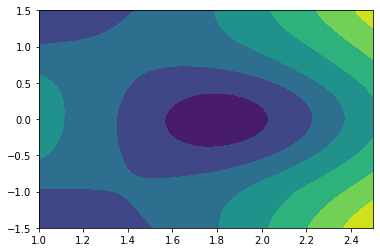

In [5]:
import matplotlib.pyplot as plt

plt.contourf(eq.RR, eq.ZZ, eq.psirz)

In [20]:
import numpy as np
ip = (-1) * 800828
q95 = 3.330114
kappa = 1.75662
betap = 1.009343
betan = 1.902915
tribot = 0.8311241
tritop = 0.359658
li = 0.841751

PCPF1U = 4282.0
PFPF1L = 0
PCPF2U = 4543.6
PFPF2L = 0
PCPF3U = (-1) * 5441.8
PFPF3L = (-1) * 5539.4
PCPF4U = (-1) * 9353.0
PFPF4L = (-1) * 10078.6
PCPF5U = (-1) * 3643.2
PFPF5L = (-1) * 4900.2
PCPF6U = 4374.0
PFPF6L = 5211.4
PCPF7U = 2316.8
PFPF7L = 0

np.savez("./toy_dataset/g028911_004060.npz", 
         R = eq.RR, Z = eq.ZZ, psi = eq.psirz, 
         ip = ip, q95 = q95, kappa = kappa, betap = betap, betan= betan, 
         tribot = tribot, tritop = tritop,
         PCPF1U = 4282.0,
         PFPF1L = 0,
        PCPF2U = 4543.6,
        PFPF2L = 0,
        PCPF3U = (-1) * 5441.8,
        PFPF3L = (-1) * 5539.4,
        PCPF4U = (-1) * 9353.0,
        PFPF4L = (-1) * 10078.6,
        PCPF5U = (-1) * 3643.2,
        PFPF5L = (-1) * 4900.2,
        PCPF6U = 4374.0,
        PFPF6L = 5211.4,
        PCPF7U = 2316.8,
        PFPF7L = 0
         )

<AxesSubplot:xlabel='R[m]', ylabel='Z[m]'>

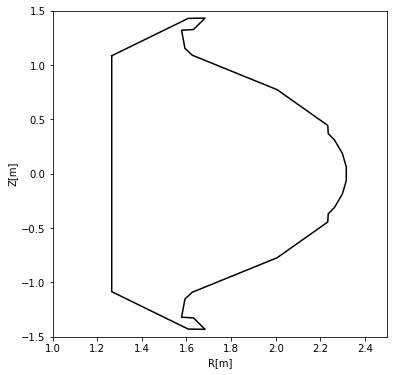

In [21]:
import numpy as np
import matplotlib.pyplot as plt


limiter_shape = np.array([
    [ 1.265,  1.085],
    [ 1.608,  1.429],
    [ 1.683,  1.431],
    [ 1.631,  1.326],
    [ 1.578,  1.32 ],
    [ 1.593,  1.153],
    [ 1.626,  1.09 ],
    [ 2.006,  0.773],
    [ 2.233,  0.444],
    [ 2.235,  0.369],
    [ 2.263,  0.31 ],
    [ 2.298,  0.189],
    [ 2.316,  0.062],
    [ 2.316, -0.062],
    [ 2.298, -0.189],
    [ 2.263, -0.31 ],
    [ 2.235, -0.369],
    [ 2.233, -0.444],
    [ 2.006, -0.773],
    [ 1.626, -1.09 ],
    [ 1.593, -1.153],
    [ 1.578, -1.32 ],
    [ 1.631, -1.326],
    [ 1.683, -1.431],
    [ 1.608, -1.429],
    [ 1.265, -1.085],
    [ 1.265,  1.085]
])

fig, ax = plt.subplots(1,1,figsize = (6,6))

def draw_KSTAR_limiter(ax):
    ax.plot(limiter_shape[:,0], limiter_shape[:,1], 'black')
    ax.set_xlim([1.0, 2.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_xlabel('R[m]')
    ax.set_ylabel('Z[m]')
    return ax

draw_KSTAR_limiter(ax)

In [43]:
ZZ[2,0]

-1.40625

In [49]:
import torch
import numpy as np

def convert_coord_index(RR, ZZ, points_arr):
    indices_arr = []
    for point in points_arr:
        x, y = point

        idx_x, idx_y = 0, 0
        nx = RR.shape[0]
        ny = RR.shape[1]
        
        for idx in range(0,nx-1):
            if (RR[0,idx] <= x) and (RR[0,idx+1] > x):
                idx_x = idx
            
        
        for idx in range(0,ny-1):
            if (ZZ[idx,0] <= y) and (ZZ[idx+1,0] > y):
                idx_y = idx
                
        indices_arr.append([idx_x, idx_y])
        
    return np.array(indices_arr)

RR = eq.RR
ZZ = eq.ZZ

indices_arr = convert_coord_index(RR,ZZ,limiter_shape)

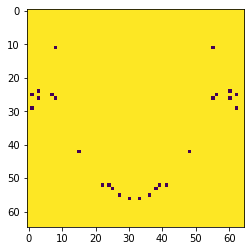

In [51]:
import scipy.ndimage as ndimage    

r = RR
contour = indices_arr

# Create an empty image to store the masked array
r_mask = np.zeros_like(r, dtype='bool')

# Create a contour image by using the contour coordinates rounded to their nearest integer value
r_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1

# Fill in the hole created by the contour boundary
r_mask = ndimage.binary_fill_holes(r_mask)

# Invert the mask since you want pixels outside of the region
r_mask = ~r_mask

plt.imshow(r_mask)

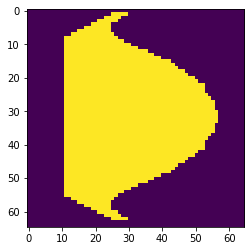

In [65]:
import numpy as np
from skimage.draw import polygon

r = RR
contour = indices_arr

# Create an empty image to store the masked array
r_mask = np.zeros_like(r, dtype='float')

rr, cc = polygon(contour[:, 0], contour[:, 1], r_mask.shape)
r_mask[cc, rr] = 1
plt.imshow(r_mask)

In [66]:
r_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])